This is a completely running code for fold 1 of EU data

In [1]:
import os
import glob
import numpy as np
import torch
import matplotlib.pyplot as plt
import monai
from monai.transforms import \
    Compose, LoadNiftid, AddChanneld, ScaleIntensityRanged, CropForegroundd, \
    RandCropByPosNegLabeld, RandAffined, Spacingd, Orientationd, ToTensord
from monai.inferers import sliding_window_inference
from monai.networks.layers import Norm
#from monai.metrics import compute_meandice
from monai.utils import set_determinism
import torch
from torch import nn
monai.config.print_config()

MONAI version: 0.1.0+626.g63eec3a
Python version: 3.7.4 (default, Jul 18 2019, 19:34:02)  [GCC 5.4.0]
Numpy version: 1.18.1
Pytorch version: 1.5.0

Optional dependencies:
Pytorch Ignite version: 0.3.0
Nibabel version: 3.1.0
scikit-image version: 0.14.2
Pillow version: 7.0.0
Tensorboard version: 2.1.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
from typing import Optional, Union

import warnings

import torch

from monai.networks import one_hot
from monai.utils import MetricReduction


class DiceMetric:
    """
    Compute average Dice loss between two tensors. It can support both multi-classes and multi-labels tasks.
    Input logits `y_pred` (BNHW[D] where N is number of classes) is compared with ground truth `y` (BNHW[D]).
    Axis N of `y_preds` is expected to have logit predictions for each class rather than being image channels,
    while the same axis of `y` can be 1 or N (one-hot format). The `include_background` class attribute can be
    set to False for an instance of DiceLoss to exclude the first category (channel index 0) which is by
    convention assumed to be background. If the non-background segmentations are small compared to the total
    image size they can get overwhelmed by the signal from the background so excluding it in such cases helps
    convergence.
    Args:
        include_background: whether to skip Dice computation on the first channel of
            the predicted output. Defaults to True.
        to_onehot_y: whether to convert `y` into the one-hot format. Defaults to False.
        mutually_exclusive: if True, `y_pred` will be converted into a binary matrix using
            a combination of argmax and to_onehot.  Defaults to False.
        sigmoid: whether to add sigmoid function to y_pred before computation. Defaults to False.
        logit_thresh: the threshold value used to convert (after sigmoid if `sigmoid=True`)
            `y_pred` into a binary matrix. Defaults to 0.5.
        reduction: {``"none"``, ``"mean"``, ``"sum"``, ``"mean_batch"``, ``"sum_batch"``, ``"mean_channel"``, ``"sum_channel"``}
            Define the mode to reduce computation result of 1 batch data. Defaults to ``"mean"``.
    """

    def __init__(
        self,
        include_background: bool = True,
        to_onehot_y: bool = False,
        mutually_exclusive: bool = False,
        sigmoid: bool = False,
        logit_thresh: float = 0.5,
        reduction: Union[MetricReduction, str] = MetricReduction.MEAN,
    ) -> None:
        super().__init__()
        self.include_background = include_background
        self.to_onehot_y = to_onehot_y
        self.mutually_exclusive = mutually_exclusive
        self.sigmoid = sigmoid
        self.logit_thresh = logit_thresh
        self.reduction: MetricReduction = MetricReduction(reduction)

        self.not_nans: Optional[torch.Tensor] = None  # keep track for valid elements in the batch

    def __call__(self, y_pred: torch.Tensor, y: torch.Tensor):

        # compute dice (BxC) for each channel for each batch
        f = compute_meandice(
            y_pred=y_pred,
            y=y,
            include_background=self.include_background,
            to_onehot_y=self.to_onehot_y,
            mutually_exclusive=self.mutually_exclusive,
            sigmoid=self.sigmoid,
            logit_thresh=self.logit_thresh,
        )

        # some dice elements might be Nan (if ground truth y was missing (zeros))
        # we need to account for it

        nans = torch.isnan(f)
        not_nans = (~nans).float()
        f[nans] = 0

        t_zero = torch.zeros(1, device=f.device, dtype=torch.float)

        if self.reduction == MetricReduction.MEAN:
            # 2 steps, first, mean by channel (accounting for nans), then by batch

            not_nans = not_nans.sum(dim=1)
            f = torch.where(not_nans > 0, f.sum(dim=1) / not_nans, t_zero)  # channel average

            not_nans = (not_nans > 0).float().sum()
            f = torch.where(not_nans > 0, f.sum() / not_nans, t_zero)  # batch average

        elif self.reduction == MetricReduction.SUM:
            not_nans = not_nans.sum()
            f = torch.sum(f)  # sum over the batch and channel dims
        elif self.reduction == MetricReduction.MEAN_BATCH:
            not_nans = not_nans.sum(dim=0)
            f = torch.where(not_nans > 0, f.sum(dim=0) / not_nans, t_zero)  # batch average
        elif self.reduction == MetricReduction.SUM_BATCH:
            not_nans = not_nans.sum(dim=0)
            f = f.sum(dim=0)  # the batch sum
        elif self.reduction == MetricReduction.MEAN_CHANNEL:
            not_nans = not_nans.sum(dim=1)
            f = torch.where(not_nans > 0, f.sum(dim=1) / not_nans, t_zero)  # channel average
        elif self.reduction == MetricReduction.SUM_CHANNEL:
            not_nans = not_nans.sum(dim=1)
            f = f.sum(dim=1)  # the channel sum
        elif self.reduction == MetricReduction.NONE:
            pass
        else:
            raise ValueError(f"reduction={self.reduction} is invalid.")

        # save not_nans since we may need it later to know how many elements were valid
        self.not_nans = not_nans

        return f


def compute_meandice(
    y_pred: torch.Tensor,
    y: torch.Tensor,
    include_background: bool = True,
    to_onehot_y: bool = False,
    mutually_exclusive: bool = False,
    sigmoid: bool = False,
    logit_thresh: float = 0.5,
):
    """Computes Dice score metric from full size Tensor and collects average.
    Args:
        y_pred: input data to compute, typical segmentation model output.
            it must be one-hot format and first dim is batch, example shape: [16, 3, 32, 32].
        y: ground truth to compute mean dice metric, the first dim is batch.
            example shape: [16, 1, 32, 32] will be converted into [16, 3, 32, 32].
            alternative shape: [16, 3, 32, 32] and set `to_onehot_y=False` to use 3-class labels directly.
        include_background: whether to skip Dice computation on the first channel of
            the predicted output. Defaults to True.
        to_onehot_y: whether to convert `y` into the one-hot format. Defaults to False.
        mutually_exclusive: if True, `y_pred` will be converted into a binary matrix using
            a combination of argmax and to_onehot.  Defaults to False.
        sigmoid: whether to add sigmoid function to y_pred before computation. Defaults to False.
        logit_thresh: the threshold value used to convert (after sigmoid if `sigmoid=True`)
            `y_pred` into a binary matrix. Defaults to 0.5.
    Returns:
        Dice scores per batch and per class, (shape [batch_size, n_classes]).
    Raises:
        ValueError: sigmoid=True is incompatible with mutually_exclusive=True.
    Note:
        This method provides two options to convert `y_pred` into a binary matrix
            (1) when `mutually_exclusive` is True, it uses a combination of ``argmax`` and ``to_onehot``,
            (2) when `mutually_exclusive` is False, it uses a threshold ``logit_thresh``
                (optionally with a ``sigmoid`` function before thresholding).
    """
    n_classes = y_pred.shape[1]
    n_len = len(y_pred.shape)

    if sigmoid:
        y_pred = y_pred.float().sigmoid()

    if n_classes == 1:
        if mutually_exclusive:
            warnings.warn("y_pred has only one class, mutually_exclusive=True ignored.")
        if to_onehot_y:
            warnings.warn("y_pred has only one channel, to_onehot_y=True ignored.")
        if not include_background:
            warnings.warn("y_pred has only one channel, include_background=False ignored.")
        # make both y and y_pred binary
        y_pred = (y_pred >= logit_thresh).float()
        y = (y > 0).float()
    else:  # multi-channel y_pred
        # make both y and y_pred binary
        if mutually_exclusive:
            if sigmoid:
                raise ValueError("sigmoid=True is incompatible with mutually_exclusive=True.")
            y_pred = torch.argmax(y_pred, dim=1, keepdim=True)
            y_pred = one_hot(y_pred, num_classes=n_classes)
        else:
            y_pred = (y_pred >= logit_thresh).float()
        if to_onehot_y:
            y = one_hot(y, num_classes=n_classes)

    if not include_background:
        y = y[:, 1:] if y.shape[1] > 1 else y
        y_pred = y_pred[:, 1:] if y_pred.shape[1] > 1 else y_pred

    assert y.shape == y_pred.shape, "Ground truth one-hot has differing shape (%r) from source (%r)" % (
        y.shape,
        y_pred.shape,
    )
    y = y.float()
    y_pred = y_pred.float()

    # reducing only spatial dimensions (not batch nor channels)
    reduce_axis = list(range(2, n_len))
    intersection = torch.sum(y * y_pred, dim=reduce_axis) + 1e-10

    y_o = torch.sum(y, reduce_axis)
    y_pred_o = torch.sum(y_pred, dim=reduce_axis)
    denominator = y_o + y_pred_o + 1e-10

    #f = torch.where(y_o > 0, (2.0 * intersection) / denominator, torch.tensor(float("nan"), device=y_o.device))
    f = (2.0 * intersection) / denominator
    return f  # returns array of Dice shape: [batch, n_classes]

In [3]:
class CrossentropyND(torch.nn.CrossEntropyLoss):
    """
    Network has to have NO NONLINEARITY!
    """
    def forward(self, inp, target):
        target = target.long()
        num_classes = inp.size()[1]

        i0 = 1
        i1 = 2

        while i1 < len(inp.shape): # this is ugly but torch only allows to transpose two axes at once
            inp = inp.transpose(i0, i1)
            i0 += 1
            i1 += 1

        inp = inp.contiguous()
        inp = inp.view(-1, num_classes)

        target = target.view(-1,)

        return super(CrossentropyND, self).forward(inp, target)
    
class SoftDiceLoss(nn.Module):
    def __init__(self, apply_nonlin=None, batch_dice=False, do_bg=True, smooth=1.):
        """
        """
        super(SoftDiceLoss, self).__init__()

        self.do_bg = do_bg
        self.batch_dice = batch_dice
        self.apply_nonlin = apply_nonlin
        self.smooth = smooth

    def forward(self, x, y, loss_mask=None):
        shp_x = x.shape

        if self.batch_dice:
            axes = [0] + list(range(2, len(shp_x)))
        else:
            axes = list(range(2, len(shp_x)))

        if self.apply_nonlin is not None:
            x = self.apply_nonlin(x)

        tp, fp, fn, _ = get_tp_fp_fn_tn(x, y, axes, loss_mask, False)

        nominator = 2 * tp + self.smooth
        denominator = 2 * tp + fp + fn + self.smooth

        dc = nominator / denominator

        if not self.do_bg:
            if self.batch_dice:
                dc = dc[1:]
            else:
                dc = dc[:, 1:]
        dc = dc.mean()

        return -dc
    
def get_tp_fp_fn_tn(net_output, gt, axes=None, mask=None, square=False):
    """
    net_output must be (b, c, x, y(, z)))
    gt must be a label map (shape (b, 1, x, y(, z)) OR shape (b, x, y(, z))) or one hot encoding (b, c, x, y(, z))
    if mask is provided it must have shape (b, 1, x, y(, z)))
    :param net_output:
    :param gt:
    :param axes: can be (, ) = no summation
    :param mask: mask must be 1 for valid pixels and 0 for invalid pixels
    :param square: if True then fp, tp and fn will be squared before summation
    :return:
    """
    if axes is None:
        axes = tuple(range(2, len(net_output.size())))

    shp_x = net_output.shape
    shp_y = gt.shape

    with torch.no_grad():
        if len(shp_x) != len(shp_y):
            gt = gt.view((shp_y[0], 1, *shp_y[1:]))

        if all([i == j for i, j in zip(net_output.shape, gt.shape)]):
            # if this is the case then gt is probably already a one hot encoding
            y_onehot = gt
        else:
            gt = gt.long()
            y_onehot = torch.zeros(shp_x)
            if net_output.device.type == "cuda":
                y_onehot = y_onehot.cuda(net_output.device.index)
            y_onehot.scatter_(1, gt, 1)

    tp = net_output * y_onehot
    fp = net_output * (1 - y_onehot)
    fn = (1 - net_output) * y_onehot
    tn = (1 - net_output) * (1 - y_onehot)

    if mask is not None:
        tp = torch.stack(tuple(x_i * mask[:, 0] for x_i in torch.unbind(tp, dim=1)), dim=1)
        fp = torch.stack(tuple(x_i * mask[:, 0] for x_i in torch.unbind(fp, dim=1)), dim=1)
        fn = torch.stack(tuple(x_i * mask[:, 0] for x_i in torch.unbind(fn, dim=1)), dim=1)
        tn = torch.stack(tuple(x_i * mask[:, 0] for x_i in torch.unbind(tn, dim=1)), dim=1)

    if square:
        tp = tp ** 2
        fp = fp ** 2
        fn = fn ** 2
        tn = tn ** 2

    if len(axes) > 0:
        tp = sum_tensor(tp, axes, keepdim=False)
        fp = sum_tensor(fp, axes, keepdim=False)
        fn = sum_tensor(fn, axes, keepdim=False)
        tn = sum_tensor(tn, axes, keepdim=False)

    return tp, fp, fn, tn

class DC_and_CE_loss(nn.Module):
    def __init__(self, soft_dice_kwargs, ce_kwargs, aggregate="sum", square_dice=False, weight_ce=1, weight_dice=1):
        """
        CAREFUL. Weights for CE and Dice do not need to sum to one. You can set whatever you want.
        :param soft_dice_kwargs:
        :param ce_kwargs:
        :param aggregate:
        :param square_dice:
        :param weight_ce:
        :param weight_dice:
        """
        super(DC_and_CE_loss, self).__init__()
        self.weight_dice = weight_dice
        self.weight_ce = weight_ce
        self.aggregate = aggregate
        self.ce = CrossentropyND(**ce_kwargs)
        self.dc = SoftDiceLoss(apply_nonlin=softmax_helper, **soft_dice_kwargs)

    def forward(self, net_output, target):
        dc_loss = self.dc(net_output, target) if self.weight_dice != 0 else 0
        ce_loss = self.ce(net_output, target) if self.weight_ce != 0 else 0
        if self.aggregate == "sum":
            result = self.weight_ce * ce_loss + self.weight_dice * dc_loss
        else:
            raise NotImplementedError("nah son") # reserved for other stuff (later)
        return result

def softmax_helper(x):
    rpt = [1 for _ in range(len(x.size()))]
    rpt[1] = x.size(1)
    x_max = x.max(1, keepdim=True)[0].repeat(*rpt)
    e_x = torch.exp(x - x_max)
    return e_x / e_x.sum(1, keepdim=True).repeat(*rpt)

def sum_tensor(inp, axes, keepdim=False):
    axes = np.unique(axes).astype(int)
    if keepdim:
        for ax in axes:
            inp = inp.sum(int(ax), keepdim=True)
    else:
        for ax in sorted(axes, reverse=True):
            inp = inp.sum(int(ax))
    return inp

In [4]:
data_dir = '/home/marafath/scratch/eu_challenge/synthetic_data'

train_images = sorted(glob.glob(os.path.join(data_dir, '*_vol.nii.gz')))
train_labels = sorted(glob.glob(os.path.join(data_dir, '*_labels.nii.gz')))
data_dicts = [{'image': image_name, 'label': label_name}
              for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[0:15], data_dicts[43:47]

In [10]:
data_dir = '/home/marafath/scratch/eu_challenge/synthetic_data'

train_images = sorted(glob.glob(os.path.join(data_dir, '*_vol.nii.gz')))
train_labels = sorted(glob.glob(os.path.join(data_dir, '*_labels.nii.gz')))
data_dicts = [{'image': image_name, 'label': label_name}
              for image_name, label_name in zip(train_images, train_labels)]

fold = 4

for i in range(0,4):
    if i == 0:
        train_files, val_files = data_dicts[0:72], data_dicts[72:96]
    elif i == 1:
        train_files = data_dicts[0:48] + data_dicts[72:96]
        val_files = data_dicts[48:72]
    elif i == 2:
        train_files = data_dicts[0:24] + data_dicts[48:96]
        val_files = data_dicts[24:48]
    elif i == 3:
        train_files, val_files = data_dicts[0:72], data_dicts[72:96] # Same as fold 1, mistake but did what expected

In [11]:
train_transforms = Compose([
    LoadNiftid(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label']),
    Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 1.5), mode=('bilinear', 'nearest')),
    Orientationd(keys=['image', 'label'], axcodes='RAS'),
    ScaleIntensityRanged(keys=['image'], a_min=-1250, a_max=250, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=['image', 'label'], source_key='image'),
    RandCropByPosNegLabeld(keys=['image', 'label'], label_key='label', spatial_size=(96, 96, 96), pos=1,
                           neg=1, num_samples=4, image_key='image', image_threshold=0),
    ToTensord(keys=['image', 'label'])
])
val_transforms = Compose([
    LoadNiftid(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label']),
    Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 1.5), mode=('bilinear', 'nearest')),
    Orientationd(keys=['image', 'label'], axcodes='RAS'),
    ScaleIntensityRanged(keys=['image'], a_min=-1250, a_max=250, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=['image', 'label'], source_key='image'),
    ToTensord(keys=['image', 'label'])
])

image shape: torch.Size([289, 289, 203]), label shape: torch.Size([289, 289, 203])


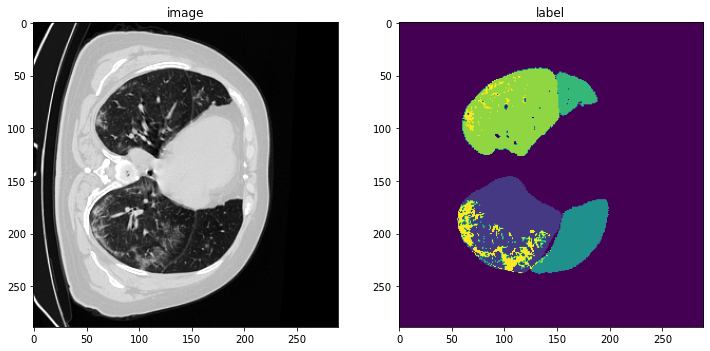

In [6]:
check_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
check_loader = monai.data.DataLoader(check_ds, batch_size=1)
check_data = monai.utils.misc.first(check_loader)
image, label = (check_data['image'][0][0], check_data['label'][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure('check', (12, 6))
plt.subplot(1, 2, 1)
plt.title('image')
plt.imshow(image[:, :, 80], cmap='gray')
plt.subplot(1, 2, 2)
plt.title('label')
plt.imshow(label[:, :, 80])
plt.show()

In [12]:
train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)
train_loader = monai.data.DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)

val_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
val_loader = monai.data.DataLoader(val_ds, batch_size=1, num_workers=4)

In [13]:
device = torch.device('cuda:0')
model = monai.networks.nets.UNet(dimensions=3, in_channels=1, out_channels=7, channels=(16, 32, 64, 128, 256),
                                 strides=(2, 2, 2, 2), num_res_units=2, norm=Norm.BATCH).to(device)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

loss_function = DC_and_CE_loss({'smooth': 1e-5, 'do_bg': False}, {})
#loss_function = monai.losses.DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-2)

In [14]:
epoch_num = 10
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data['image'].to(device), batch_data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.
            metric_count = 0
            for val_data in val_loader:
                val_inputs, val_labels = val_data['image'].to(device), val_data['label'].to(device)
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                value = compute_meandice(y_pred=val_outputs, y=val_labels, include_background=False,
                                         to_onehot_y=True, mutually_exclusive=True)
                metric_count += len(value)
                metric_sum += value.sum().item()
            metric = metric_sum / metric_count
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('saved new best metric model')
            print(f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                  f"\nbest mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/10
1/72, train_loss: 2.1179
2/72, train_loss: 1.3618
3/72, train_loss: 0.9387
4/72, train_loss: 0.9674
5/72, train_loss: 0.9964
6/72, train_loss: 0.9399
7/72, train_loss: 0.8239
8/72, train_loss: 1.0521
9/72, train_loss: 1.0455
10/72, train_loss: 0.7880
11/72, train_loss: 0.6173
12/72, train_loss: 0.8752
13/72, train_loss: 0.6791
14/72, train_loss: 0.6268
15/72, train_loss: 0.6279
16/72, train_loss: 0.5467
17/72, train_loss: 1.3426
18/72, train_loss: 0.7392
19/72, train_loss: 0.5774
20/72, train_loss: 0.7327
21/72, train_loss: 0.8559
22/72, train_loss: 0.7144
23/72, train_loss: 0.5967
24/72, train_loss: 0.8940
25/72, train_loss: 0.5919
26/72, train_loss: 0.5641
27/72, train_loss: 0.6230
28/72, train_loss: 0.3740
29/72, train_loss: 0.7003
30/72, train_loss: 0.7288
31/72, train_loss: 0.7303
32/72, train_loss: 0.5709
33/72, train_loss: 0.6428
34/72, train_loss: 0.8123
35/72, train_loss: 0.5869
36/72, train_loss: 0.3832
37/72, train_loss: 0.6051
38/72, train_loss: 0.7908

KeyboardInterrupt: 